# This is how a neural network learns to add, multiply and compare handwritten digits Without knowing their values 

<p align="center"> <img src="https://i.dlpng.com/static/png/6906777_preview.png"> </p>   

I described in a [previous post](https://blog.jovian.ai/how-to-train-supervised-machine-learning-algorithms-without-labeled-data-6ebddc01a00f), how useful are autoencoders in  automated labeling. The main property of these networks is their ability to learn features/patterns in the data. This is in fact not specific to autoencoders and can be implemented using other unsupervised techniques, mainly **PCA**.  
The ability to detect and learn features in data can be used in other areas.  

In this post, I will present some applications of convolutional autoencoders:  
- First, a convolutional autoencoder will be trained on **MNIST** data.
- After the training of the encoder and decoder, we will freeze their weights and use them with additional dense layers to "learn" arithmetic operations, namely addition, multiplication and comparison.  
The trick is to *never* explicitly associate the handwritten digits in **MNIST** dataset with their respective labels. We will see that the neural networks will be nevertheless able to reach 97+% accuracy in all cases on unseen data.

The first step is described in the following diagram:
<p align="center"> <img src="https://i.imgur.com/chLUEdp.png"> </p>   

In the second step, we will use the encoder in series with dense layers to perform arithmetic operations: addition, multiplication and comparison. We will train only the dense layer weights, and supply the results of the operations as labels. note that we will not supply the digits values (labels).

<p align="center"> <img src="https://i.imgur.com/s8U8up4.png"> </p> 


# Training an autoencoder on MNIST data

Similar to the previous article, we will use MNIST data in this experiment. The autoencoder will learn the handwritten digits features using 60000 training samples. We import MNIST using *KERAS* library.

In [33]:
#import libraries and setup 
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Input
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)

In [4]:
# import mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


We scale the data in the range `[0,1]` and reshape it to *KERAS* format for pictures (nbr_samples x width x height x channels) 

In [5]:
#normalize data
if x_train.max() >1:
    x_train = x_train / 255
    x_test = x_test / 255

default_shape = x_train.shape
#reshape input data to 1 channel
x_train = x_train.reshape(-1,default_shape[1],default_shape[2],1)
x_test = x_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = x_train.shape[1:]

We will implement a similar autoencoder architecture as in [[1]](https://blog.jovian.ai/how-to-train-supervised-machine-learning-algorithms-without-labeled-data-6ebddc01a00f). It is based on a series of convolutional layers, that will gradually encode the 28x28 image (784 pixel) into a 100 elements array, and decode that representation back to the original format. The resulting image -after the training step- will hopefully resemble to the original one.

In [12]:
# create an autoencoder / decoder 
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu',input_shape=image_dim))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(Flatten())
encoder.add(Dense(100,activation='sigmoid'))
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

In [13]:
encoder_out_dim = encoder.layers[-1].output_shape[1:] # dimension of the encoder output

In [14]:
decoder = Sequential()
decoder.add(Dense(6272, activation='sigmoid', input_shape=encoder_out_dim))
decoder.add(Reshape(( 7, 7, 128)))
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))

decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 1)        

The autoencoder is created using the encoder and the decoder:

In [17]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 100)               719972    
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         855425    
Total params: 1,575,397
Trainable params: 1,575,397
Non-trainable params: 0
_________________________________________________________________


It will be trained as a set of binary classifiers for each pixel.

In [18]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy')
history = enc_dec.fit(x_train,x_train, batch_size=1000,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es,es])

Epoch 1/1000
48/48 - 10s - loss: 0.3642 - val_loss: 0.2719
Epoch 2/1000
48/48 - 10s - loss: 0.2715 - val_loss: 0.2730
Epoch 3/1000
48/48 - 10s - loss: 0.2666 - val_loss: 0.2650
Epoch 4/1000
48/48 - 10s - loss: 0.2644 - val_loss: 0.2637
Epoch 5/1000
48/48 - 10s - loss: 0.2393 - val_loss: 0.2135
Epoch 6/1000
48/48 - 10s - loss: 0.1882 - val_loss: 0.1649
Epoch 7/1000
48/48 - 10s - loss: 0.1552 - val_loss: 0.1430
Epoch 8/1000
48/48 - 10s - loss: 0.1366 - val_loss: 0.1323
Epoch 9/1000
48/48 - 10s - loss: 0.1287 - val_loss: 0.1562
Epoch 10/1000
48/48 - 10s - loss: 0.4014 - val_loss: 0.1864
Epoch 11/1000
48/48 - 10s - loss: 0.1611 - val_loss: 0.1513
Epoch 12/1000
48/48 - 10s - loss: 0.1406 - val_loss: 0.1345
Epoch 13/1000
48/48 - 10s - loss: 0.1305 - val_loss: 0.1288
Epoch 14/1000
48/48 - 10s - loss: 0.1241 - val_loss: 0.1244
Epoch 15/1000
48/48 - 10s - loss: 0.1191 - val_loss: 0.1170
Epoch 16/1000
48/48 - 10s - loss: 0.1144 - val_loss: 0.1148
Epoch 17/1000
48/48 - 10s - loss: 0.1115 - val_lo

The early stopping will make sure the autoencoder will not overfit the training data. There are two ways to verify the network. First, we can evaluate the loss function on test data, and expect it to be close to the loss value on the training data.

In [21]:
enc_dec.evaluate(x_test,x_test,batch_size=1000)

10/10 [==============================] - 1s 75ms/step - loss: 0.0801


0.08007277548313141

In [22]:
enc_dec.evaluate(x_train,x_train,batch_size=1000)

60/60 [==============================] - 5s 75ms/step - loss: 0.0806


0.08060310781002045

It is very close, around `0.08` for both data sets. The second method is to check the resulting reconstitution that we obtain for a random sample from the test data.

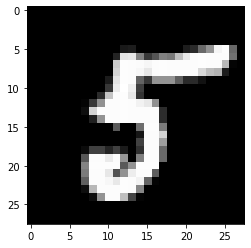

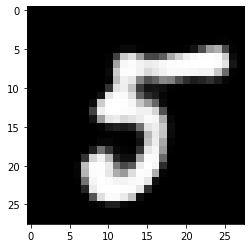

In [28]:
random_label = np.random.randint(0,9999)
img_sample = x_test[random_label,:,:].reshape((1,28,28,1))
plt.imshow(img_sample.reshape(28,28), cmap='gray');
pred_img = enc_dec.predict(img_sample) 
plt.figure();
plt.imshow(pred_img.reshape(28,28), cmap='gray');

*A picture is worth a thousand words!* Just to be on the safe side, I ran this test multiple times and the results were consistent. Let's save the encoder and the decoder.

In [29]:
# save models
encoder.save('encoder')
decoder.save('decoder')

Now we have a trained encoder and decoder, let's focus on the *encoder*. For each image, is associated a representation that captures most of the interesting features. This representation is sufficient to reconstitute the image using the decoder. Here is the representation of the sample image we used earlier: 

In [30]:
representation_sample = encoder.predict(img_sample)
print(representation_sample) 

[[0.18486543 0.5697806  0.25546345 0.513535   0.47046018 0.23013075
  0.11007436 0.08223282 0.92961174 0.34727788 0.20599699 0.31574652
  0.5037295  0.67289937 0.4258053  0.05625024 0.6901649  0.32541478
  0.72563386 0.1158777  0.22629336 0.10287777 0.38414446 0.880189
  0.18952799 0.22327262 0.49226147 0.04139815 0.6070379  0.67899853
  0.1930634  0.9533057  0.26226565 0.3571257  0.10029613 0.64641505
  0.7480828  0.6451894  0.19870374 0.8850102  0.65947354 0.6287513
  0.6176214  0.5163804  0.25737226 0.14717074 0.09626418 0.78674656
  0.8884231  0.7183272  0.40912864 0.25173852 0.6504716  0.73822445
  0.21953063 0.794006   0.36661652 0.29903716 0.9652254  0.56687284
  0.819398   0.10387004 0.18816645 0.631493   0.17954373 0.8222881
  0.37873647 0.8320993  0.1338265  0.6080741  0.35885492 0.6325537
  0.6959548  0.06192173 0.29763156 0.75721514 0.665339   0.24818887
  0.19820885 0.23145263 0.32199287 0.87531734 0.49698454 0.5838976
  0.2733242  0.7204009  0.9374683  0.5761113  0.943867

Using these 100 numbers, we generate a 28x28 image (784 pixels).

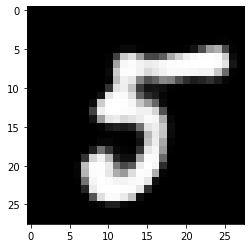

In [31]:
recons_image = decoder.predict(representation_sample)
plt.imshow(recons_image.reshape(28,28), cmap='gray');

And here is where the *fun part* begins! using the lower-dimension representation, let's do some math.

# Learning how to add two handwritten digits

The idea is simple. Using the representation of two images, we train a neural network to compute their sum. We will not provide the value of each digit, but we will provide the sum during the training step.  
We will be performing addition between numbers in the range [0-9]. The results will be in the range [0-18]. So the results will be coded using two outputs:  
1- Units, multiclass output [0,1,2,3,4,5,6,7,8,9]  
2- Tens, binary output [0,1]  

<p align="center"> <img src="https://i.imgur.com/Zgnd82F.png"> </p> 


Using the functional API in *KERAS* we define the network architecture. First, we import the encoder *twice* and freeze its weights:

In [32]:
# duplicate encoders and freeze weights
encoder1 = keras.models.load_model('encoder') 
encoder1._name = 'encoder1'
encoder1.trainable = False

encoder2 = keras.models.load_model('encoder')
encoder2._name = 'encoder2'
encoder2.trainable = False

Using the encoders, we build the 'addition' model:

In [36]:
# create model to learn addition
input1 = Input(shape=image_dim)
input2 = Input(shape=image_dim)
enc1_out = encoder1(input1)
enc2_out = encoder2(input2)
model_c = Concatenate()([enc1_out,enc2_out])
model_c = Dense(1000,activation='relu')(model_c)

model_b1 = Dense(200,activation='relu')(model_c)
model_b2 = Dense(200,activation='relu')(model_c)

model_b1 = Dense(100,activation='relu')(model_b1)
model_b2 = Dense(100,activation='relu')(model_b2)

units =  Dense(10,activation='softmax',name ='units')(model_b1)
tens = Dense(1,activation='sigmoid',name ='tens')(model_b2)

model_addition = Model(inputs=[input1,input2],outputs=[units,tens])

model_addition.compile(optimizer='nadam', loss = ['categorical_crossentropy','binary_crossentropy'], metrics=['acc'])

This model has two inputs (the two handwritten digits images) and two outputs (units and tens of the sum). We will use two different losses due to the nature of the outputs. Note that there is a common hidden layer of 1000 units, and then two branches (one for each output).  
We need to create datasets to train and test our model. Inputs will be random combinations of handwritten digits. Outputs will be the sums for each combination. 

In [39]:
# generate a dataset for additions
train_size = 200000
random_labels1 = np.random.randint(0,25000,train_size)
random_labels2 = np.random.randint(0,25000,train_size)

x_train_1 = x_train[random_labels1]
x_train_2 = x_train[random_labels2]

y_train_1 = y_train[random_labels1]
y_train_2 = y_train[random_labels2]

y_add = y_train_1 + y_train_2
y_add_tens = y_add //10 
y_add_units = y_add %10 
y_add_units_cat = to_categorical(y_add_units)


# the same with x_test
test_size = 5000
random_labels1 = np.random.randint(0,10000,test_size)
random_labels2 = np.random.randint(0,10000,test_size)

x_test_1 = x_test[random_labels1]
x_test_2 = x_test[random_labels2]

y_test_1 = y_test[random_labels1]
y_test_2 = y_test[random_labels2]

y_test_add = y_test_1 + y_test_2
y_test_add_tens = y_test_add //10 
y_test_add_units = y_test_add %10 
y_test_add_units_cat = to_categorical(y_test_add_units)

Now we are ready to train our model! 

In [40]:
history_addition = model_addition.fit([x_train_1,x_train_2],[y_add_units_cat,y_add_tens], batch_size=100,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es,es])

Epoch 1/1000
1600/1600 - 32s - loss: 1.2062 - units_loss: 0.9615 - tens_loss: 0.2448 - units_acc: 0.6746 - tens_acc: 0.8922 - val_loss: 0.5480 - val_units_loss: 0.4246 - val_tens_loss: 0.1234 - val_units_acc: 0.8713 - val_tens_acc: 0.9549
Epoch 2/1000
1600/1600 - 29s - loss: 0.4051 - units_loss: 0.3110 - tens_loss: 0.0941 - units_acc: 0.9051 - tens_acc: 0.9653 - val_loss: 0.3432 - val_units_loss: 0.2617 - val_tens_loss: 0.0816 - val_units_acc: 0.9190 - val_tens_acc: 0.9695
Epoch 3/1000
1600/1600 - 29s - loss: 0.2549 - units_loss: 0.1957 - tens_loss: 0.0592 - units_acc: 0.9396 - tens_acc: 0.9786 - val_loss: 0.2623 - val_units_loss: 0.1953 - val_tens_loss: 0.0670 - val_units_acc: 0.9401 - val_tens_acc: 0.9749
Epoch 4/1000
1600/1600 - 32s - loss: 0.1781 - units_loss: 0.1367 - tens_loss: 0.0413 - units_acc: 0.9570 - tens_acc: 0.9849 - val_loss: 0.2058 - val_units_loss: 0.1577 - val_tens_loss: 0.0481 - val_units_acc: 0.9503 - val_tens_acc: 0.9823
Epoch 5/1000
1600/1600 - 29s - loss: 0.1319 

At the end of the training, the accuracy on both outputs is pretty good (98% and 99,5%). Let's see first how the model performs on the test data.

In [41]:
test_results = model_addition.evaluate([x_test_1,x_test_2],[y_test_add_units_cat,y_test_add_tens],batch_size=1000)

5/5 [==============================] - 0s 51ms/step - loss: 0.4157 - units_loss: 0.3104 - tens_loss: 0.1052 - units_acc: 0.9398 - tens_acc: 0.9806


Results are still in the 9x%. We can show a random sample of the model predictions.

sum = [[4.]]


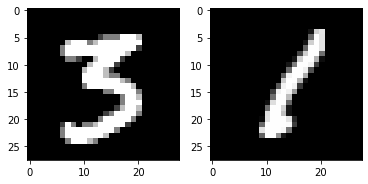

In [60]:
random_label_1 = np.random.randint(0,9999)
random_label_2 = np.random.randint(0,9999)

img_sample1 = x_test[random_label_1,:,:].reshape((1,28,28,1))
img_sample2 = x_test[random_label_2,:,:].reshape((1,28,28,1))

plt.subplot(1,2,1)
plt.imshow(img_sample1.reshape(28,28), cmap='gray');

plt.subplot(1,2,2)
plt.imshow(img_sample2.reshape(28,28), cmap='gray');

prediction = model_addition.predict([img_sample1,img_sample2])
unit = prediction[0]
ten = prediction[1]

sum_images = np.argmax(unit)+10*np.round(ten)
print('sum =',sum_images)

Results look promising! We actually could improve the accuracy by training the model on more random samples (increase `train_size` value) or tweak the model architecture. One last thing: save the model!

In [58]:
# save the model
model_addition.save('model_addition')

# Learning how to multiply two handwritten digits

Using a similar method, we can train a neural network to compute multiplication result of two handwritten digits. The main difference is that the output will be in the range [0,81]. The network will output two values:  
1- units, multiclass [0,1,2,3,4,5,6,7,8,9]  
2- tens, multiclass [0,1,2,3,4,5,6,7,8] 

We will use the same architecture as previously, with a slight modification in the output layer (softmax instead of sigmoid, and 8 neurons instead of 1)

In [61]:
# duplicate encoders and freeze weights
encoder3 = keras.models.load_model('encoder') 
encoder3._name = 'encoder1'
encoder3.trainable = False

encoder4 = keras.models.load_model('encoder')
encoder4._name = 'encoder2'
encoder4.trainable = False

In [64]:
# create model to learn multiplication
input1 = Input(shape=image_dim)
input2 = Input(shape=image_dim)
enc1_out = encoder3(input1)
enc2_out = encoder4(input2)
model_c = Concatenate()([enc1_out,enc2_out])
model_c = Dense(1000,activation='relu')(model_c)

model_b1 = Dense(200,activation='relu')(model_c)
model_b2 = Dense(200,activation='relu')(model_c)

model_b1 = Dense(100,activation='relu')(model_b1)
model_b2 = Dense(100,activation='relu')(model_b2)

units =  Dense(10,activation='softmax',name ='units')(model_b1)
tens = Dense(9,activation='softmax',name ='tens')(model_b2)

model_mult = Model(inputs=[input1,input2],outputs=[units,tens])

model_mult.compile(optimizer='nadam', loss = ['categorical_crossentropy','categorical_crossentropy'], metrics=['acc'])

Now we need to create data for training and testing as we did previously. We already generated random images, so all we need now is to create labels by multiplying the values.

In [66]:
# generate a dataset for multiplication

y_mult = y_train_1 * y_train_2
y_mult_tens = y_mult //10 
y_mult_units = y_mult %10 
y_mult_units_cat = to_categorical(y_mult_units)
y_mult_tens_cat = to_categorical(y_mult_tens)

# the same with x_test

y_test_mult = y_test_1 * y_test_2
y_test_mult_tens = y_test_mult //10 
y_test_mult_units = y_test_mult %10 
y_test_mult_units_cat = to_categorical(y_test_mult_units)
y_test_mult_tens_cat = to_categorical(y_test_mult_tens)

Next step is to train the model, and test it.

In [65]:
history_mult = model_mult.fit([x_train_1,x_train_2],[y_mult_units_cat,y_mult_tens_cat], batch_size=100,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es,es])

Epoch 1/1000
1600/1600 - 31s - loss: 1.2452 - units_loss: 0.6768 - tens_loss: 0.5684 - units_acc: 0.7661 - tens_acc: 0.7980 - val_loss: 0.5906 - val_units_loss: 0.3276 - val_tens_loss: 0.2630 - val_units_acc: 0.8949 - val_tens_acc: 0.9129
Epoch 2/1000
1600/1600 - 30s - loss: 0.4313 - units_loss: 0.2278 - tens_loss: 0.2034 - units_acc: 0.9279 - tens_acc: 0.9327 - val_loss: 0.3499 - val_units_loss: 0.1837 - val_tens_loss: 0.1662 - val_units_acc: 0.9413 - val_tens_acc: 0.9459
Epoch 3/1000
1600/1600 - 29s - loss: 0.2800 - units_loss: 0.1479 - tens_loss: 0.1321 - units_acc: 0.9523 - tens_acc: 0.9569 - val_loss: 0.2667 - val_units_loss: 0.1405 - val_tens_loss: 0.1262 - val_units_acc: 0.9544 - val_tens_acc: 0.9579
Epoch 4/1000
1600/1600 - 30s - loss: 0.2003 - units_loss: 0.1051 - tens_loss: 0.0952 - units_acc: 0.9653 - tens_acc: 0.9683 - val_loss: 0.2363 - val_units_loss: 0.1202 - val_tens_loss: 0.1161 - val_units_acc: 0.9620 - val_tens_acc: 0.9636
Epoch 5/1000
1600/1600 - 31s - loss: 0.1500 

In [67]:
test_results = model_mult.evaluate([x_test_1,x_test_2],[y_test_mult_units_cat,y_test_mult_tens_cat],batch_size=1000)

5/5 [==============================] - 0s 45ms/step - loss: 0.4278 - units_loss: 0.2224 - tens_loss: 0.2053 - units_acc: 0.9544 - tens_acc: 0.9602


We achieve similar performances (slightly better actually!) when compared to addition. Let's see how the model works on sample data: 

multiplication result = 63


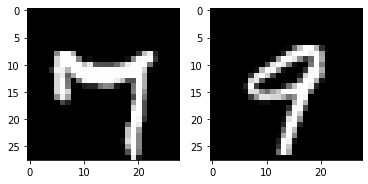

In [81]:
random_label_1 = np.random.randint(0,9999)
random_label_2 = np.random.randint(0,9999)

img_sample1 = x_test[random_label_1,:,:].reshape((1,28,28,1))
img_sample2 = x_test[random_label_2,:,:].reshape((1,28,28,1))

plt.subplot(1,2,1)
plt.imshow(img_sample1.reshape(28,28), cmap='gray');

plt.subplot(1,2,2)
plt.imshow(img_sample2.reshape(28,28), cmap='gray');

prediction = model_mult.predict([img_sample1,img_sample2])
unit = prediction[0]
ten = prediction[1]

mult_images = np.argmax(unit)+10*np.argmax(ten)
print('multiplication result =',mult_images)

In [70]:
# save the model
model_mult.save('model_mult')

# Learning how to compare two handwritten digits

The last arithmetic operation our model will predict is the comparison. The model will have one binary output (1 if image1 > image2 and 0 elsewhere). We proceed the same way as previously.

In [71]:
# duplicate encoders and freeze weights
encoder5 = keras.models.load_model('encoder') 
encoder5._name = 'encoder1'
encoder5.trainable = False

encoder6 = keras.models.load_model('encoder')
encoder6._name = 'encoder2'
encoder6.trainable = False

In [72]:
# create model to learn comparison
input1 = Input(shape=image_dim)
input2 = Input(shape=image_dim)
enc1_out = encoder5(input1)
enc2_out = encoder6(input2)
model_c = Concatenate()([enc1_out,enc2_out])
model_c = Dense(1000,activation='relu')(model_c)

model_c = Dense(200,activation='relu')(model_c)

model_c = Dense(100,activation='relu')(model_c)

comp =  Dense(1,activation='sigmoid',name ='units')(model_c)


model_comp = Model(inputs=[input1,input2],outputs=[comp])

model_comp.compile(optimizer='nadam', loss = ['binary_crossentropy'], metrics=['acc'])

In [76]:
# generate a dataset for comparison
y_comp = y_train_1 > y_train_2

# the same with x_test
y_test_comp = y_test_1 > y_test_2

In [74]:
history_comp = model_comp.fit([x_train_1,x_train_2],y_comp, batch_size=100,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es])

Epoch 1/1000
1600/1600 - 24s - loss: 0.2903 - acc: 0.8694 - val_loss: 0.1704 - val_acc: 0.9336
Epoch 2/1000
1600/1600 - 22s - loss: 0.1518 - acc: 0.9406 - val_loss: 0.1260 - val_acc: 0.9513
Epoch 3/1000
1600/1600 - 23s - loss: 0.1121 - acc: 0.9570 - val_loss: 0.1129 - val_acc: 0.9569
Epoch 4/1000
1600/1600 - 22s - loss: 0.0887 - acc: 0.9670 - val_loss: 0.0984 - val_acc: 0.9627
Epoch 5/1000
1600/1600 - 22s - loss: 0.0733 - acc: 0.9727 - val_loss: 0.0882 - val_acc: 0.9678
Epoch 6/1000
1600/1600 - 22s - loss: 0.0635 - acc: 0.9763 - val_loss: 0.0821 - val_acc: 0.9700
Epoch 7/1000
1600/1600 - 23s - loss: 0.0554 - acc: 0.9795 - val_loss: 0.0670 - val_acc: 0.9762
Epoch 8/1000
1600/1600 - 23s - loss: 0.0487 - acc: 0.9820 - val_loss: 0.0719 - val_acc: 0.9739
Epoch 9/1000
1600/1600 - 24s - loss: 0.0430 - acc: 0.9843 - val_loss: 0.0620 - val_acc: 0.9775
Epoch 10/1000
1600/1600 - 25s - loss: 0.0385 - acc: 0.9857 - val_loss: 0.0671 - val_acc: 0.9771
Epoch 11/1000
1600/1600 - 23s - loss: 0.0345 - ac

In [77]:
test_results = model_comp.evaluate([x_test_1,x_test_2],y_test_comp,batch_size=1000)

5/5 [==============================] - 0s 50ms/step - loss: 0.1200 - acc: 0.9700


comparison result = [[0.]] 1 if the number on the left is greater, 0 elsewhere


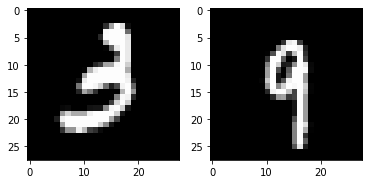

In [80]:
random_label_1 = np.random.randint(0,9999)
random_label_2 = np.random.randint(0,9999)

img_sample1 = x_test[random_label_1,:,:].reshape((1,28,28,1))
img_sample2 = x_test[random_label_2,:,:].reshape((1,28,28,1))

plt.subplot(1,2,1)
plt.imshow(img_sample1.reshape(28,28), cmap='gray');

plt.subplot(1,2,2)
plt.imshow(img_sample2.reshape(28,28), cmap='gray');

prediction = np.round(model_comp.predict([img_sample1,img_sample2]))


print('comparison result =',prediction,'1 if the number on the left is greater, 0 elsewhere')

In [ ]:
# save the model
model_comp.save('model_comp')

# Conclusion and future work